In [0]:
!apt-get install -y -qq software-properties-common module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131352 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&acces

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive
import os
os.mkdir("drive/extract-frames")
os.chdir("drive/extract-frames")

In [0]:
import cv2     # for capturing videos
import math   # for mathematical operations
import matplotlib.pyplot as plt    # for plotting the images
%matplotlib inline
import pandas as pd
from keras.preprocessing import image   # for preprocessing the images
import numpy as np    # for mathematical operations
from keras.utils import np_utils
from skimage.transform import resize   # for resizing images

### 1. Read the video, extract frames from it and save them as images

In [0]:
count = 0
cap = cv2.VideoCapture("Tom and jerry.mp4")
frameRate = cap.get(5)
x=1

while cap.isOpened():
    frameId = cap.get(1) #current frame number
    ret, frame = cap.read()
    if (ret != True):
        break
    if frameId % math.floor(frameRate) == 0:
        filename ="frame%d.jpg" % count
        count += 1
        cv2.imwrite(filename, frame)
cap.release()

print ("Done!")

Done!


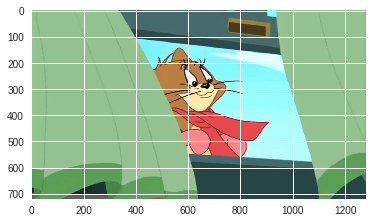

In [0]:
img = plt.imread('frame0.jpg')
plt.imshow(img)

### 2. Label a few images for training the model
0 – neither JERRY nor TOM<br>
1 – for JERRY<br>
2 – for TOM<br>

In [0]:
data = pd.read_csv('mapping.csv')     # reading the csv file
data.head()      # printing first five rows of the file

,Image_ID,Class
0,frame0.jpg,1
1,frame1.jpg,1
2,frame2.jpg,2
3,frame3.jpg,2
4,frame4.jpg,2


In [0]:
X = []
for img_name in data.Image_ID:
    img = plt.imread('' + img_name)
    X.append(img)

X = np.array(X)

In [0]:
y = data.Class
dummy_y = np_utils.to_categorical(y)

Images have to be resized, because we will be using a VGG16 pretrained model which takes an input image of shape (224 x 224 x 3).

In [0]:
image = []

for i in range(0, X.shape[0]):
    # Reshape to 224 * 224 * 3.
    a = resize(X[i], preserve_range=True, output_shape=(224,224)).astype(int)
    image.append(a)

X = np.array(image)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Preprocess the input as per the model's requirement:

In [0]:
from keras.applications.vgg16 import preprocess_input
X = preprocess_input(X, mode='tf')

Divide images into training and validation set:

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, dummy_y, test_size=0.3, random_state=42)

### 3. Building the model

In [0]:
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, InputLayer, Dropout

In [0]:
# include_top=False to remove the top layer.
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 7s 0us/step


We will make predictions using this model for X_train and X_valid, get the features, and then use those features to retrain the model.

In [0]:
X_train = base_model.predict(X_train)
X_valid = base_model.predict(X_valid)
X_train.shape, X_valid.shape

((208, 7, 7, 512), (90, 7, 7, 512))

The shape of X_train and X_valid is (208, 7, 7, 512), (90, 7, 7, 512) respectively. In order to pass it to our neural network, we have to reshape it to 1-D.

In [0]:
X_train = X_train.reshape(208, 7 * 7 * 512)
X_valid = X_valid.reshape(90, 7 * 7 * 512)

We will now preprocess the images and make them zero-centered which helps the model to converge faster.

In [0]:
train = X_train/X_train.max()
X_valid = X_valid/X_train.max()

#### 3.1 Building the model 

In [0]:
model = Sequential()
model.add(InputLayer((7 * 7 * 512, )))
model.add(Dense(units=1024, activation='sigmoid'))   # hidden layer
model.add(Dropout(0.5))                              # adding dropout
model.add(Dense(units=512, activation='sigmoid'))    # hidden layer
model.add(Dropout(0.5))                              # adding dropout
model.add(Dense(units=256, activation='sigmoid'))    # hidden layer
model.add(Dropout(0.5))                              # adding dropout
model.add(Dense(3, activation='softmax'))            # output layer

model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
___________________________

#### 3.2 Compiling the model

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#### 3.3 Training the model

Tom appears more often than Jerry, so we want to give Tom a smaller weight.

In [0]:
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight

class_weights = compute_class_weight('balanced', np.unique(data.Class), data.Class)

In [0]:
from keras.callbacks import ModelCheckpoint
filepath="weights.best.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]      # model check pointing based on validation loss

In [0]:
model.fit(train, y_train, epochs=100, validation_data=(X_valid, y_valid),
          class_weight=class_weights, callbacks=callbacks_list)

Train on 208 samples, validate on 90 samples
Epoch 1/100
208/208 [==============================] - 4s 19ms/step - loss: 1.3536 - acc: 0.3510 - val_loss: 1.1646 - val_acc: 0.3889

Epoch 00001: val_loss improved from inf to 1.16462, saving model to weights.best.hdf5
Epoch 2/100
208/208 [==============================] - 3s 16ms/step - loss: 1.2653 - acc: 0.4279 - val_loss: 1.0326 - val_acc: 0.5556

Epoch 00002: val_loss improved from 1.16462 to 1.03255, saving model to weights.best.hdf5
Epoch 3/100
208/208 [==============================] - 3s 15ms/step - loss: 1.2620 - acc: 0.3942 - val_loss: 1.0670 - val_acc: 0.5667

Epoch 00003: val_loss did not improve from 1.03255
Epoch 4/100
208/208 [==============================] - 3s 15ms/step - loss: 1.0972 - acc: 0.4808 - val_loss: 0.9787 - val_acc: 0.5667

Epoch 00004: val_loss improved from 1.03255 to 0.97871, saving model to weights.best.hdf5
Epoch 5/100
208/208 [==============================] - 3s 15ms/step - loss: 1.0202 - acc: 0.4663 -

### Using the model on new videos

In [0]:
count = 0
videoFile = "Tom and Jerry 3.mp4"
cap = cv2.VideoCapture(videoFile)
frameRate = cap.get(5)
x = 1

while cap.isOpened():
    frameId = cap.get(1)
    ret, frame = cap.read()
    if ret != True:
        break
    if frameId % math.floor(frameRate) == 0:
        filename ="test%d.jpg" % count
        count += 1
        cv2.imwrite(filename, frame)
cap.release()

print ("Done!")

Done!


In [0]:
test = pd.read_csv('test.csv')

In [0]:
test_image = []
for img_name in test.Image_ID:
    img = plt.imread('' + img_name)
    test_image.append(img)
test_img = np.array(test_image)

In [0]:
test_image = []
for i in range(0,test_img.shape[0]):
    a = resize(test_img[i], preserve_range=True, output_shape=(224, 224)).astype(int)
    test_image.append(a)
test_image = np.array(test_image)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
# preprocessing the images
test_image = preprocess_input(test_image, mode='tf')

# extracting features from the images using pretrained model
test_image = base_model.predict(test_image)

# converting the images to 1-D form
test_image = test_image.reshape(186, 7*7*512)

# zero centered images
test_image = test_image/test_image.max()

In [0]:
model.load_weights("weights.best.hdf5")
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

predictions = model.predict_classes(test_image)

In [0]:
print("The screen time of JERRY is", predictions[predictions==1].shape[0], "seconds")
print("The screen time of TOM is", predictions[predictions==2].shape[0], "seconds")

The screen time of JERRY is 12 seconds
The screen time of TOM is 115 seconds
